In [ ]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import os 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Import the data

In [ ]:
PATH = '../input/predict-volcanic-eruptions-ingv-oe/'

train_list = os.listdir('../input/predict-volcanic-eruptions-ingv-oe/train')
test_list = os.listdir("../input/predict-volcanic-eruptions-ingv-oe/test")
train_time = pd.read_csv(PATH + 'train.csv')

Train and Test size

In [ ]:
print('Number of train files: {}'.format(len(train_list)))
print('Number of test files: {}'.format(len(test_list )))

Number of train files: 4431
Number of test files: 4520


In [ ]:
example = pd.read_csv(PATH + 'train/' + train_list[0])

We can transform our signals in 1 row

In [ ]:
example[:5]

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
0,-560.0,-508.0,NaN,-261.0,-348.0,1681.0,-764.0,-1193.0,NaN,-516.0
1,-508.0,-460.0,NaN,-276.0,-252.0,1934.0,-774.0,-1276.0,NaN,-537.0
2,-630.0,-260.0,NaN,-310.0,-174.0,2229.0,-785.0,-1298.0,NaN,-535.0
3,-587.0,1.0,NaN,-352.0,-69.0,2069.0,-788.0,-1249.0,NaN,-507.0
4,-778.0,240.0,NaN,-390.0,71.0,1850.0,-825.0,-1402.0,NaN,-437.0


In [ ]:
example_test = pd.read_csv(PATH + 'test/' + test_list[0])

In [ ]:
example_test[:5]

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
0,-511.0,NaN,-131.0,-457.0,47.0,-35.0,185.0,367.0,858.0,-492.0
1,-556.0,NaN,-105.0,-534.0,-7.0,-84.0,190.0,195.0,881.0,-368.0
2,-615.0,NaN,-97.0,-473.0,-50.0,8.0,219.0,327.0,937.0,-260.0
3,-682.0,NaN,-75.0,-388.0,-58.0,28.0,255.0,-249.0,995.0,-187.0
4,-763.0,NaN,-18.0,-358.0,-53.0,-104.0,271.0,-162.0,1032.0,-160.0


In [ ]:
train_list[0]

'800654756.csv'

In [ ]:
train_time

,segment_id,time_to_eruption
0,1136037770,12262005
1,1969647810,32739612
2,1895879680,14965999
3,2068207140,26469720
4,192955606,31072429
...,...,...
4426,873340274,15695097
4427,1297437712,35659379
4428,694853998,31206935
4429,1886987043,9598270


Look at one of the train signal

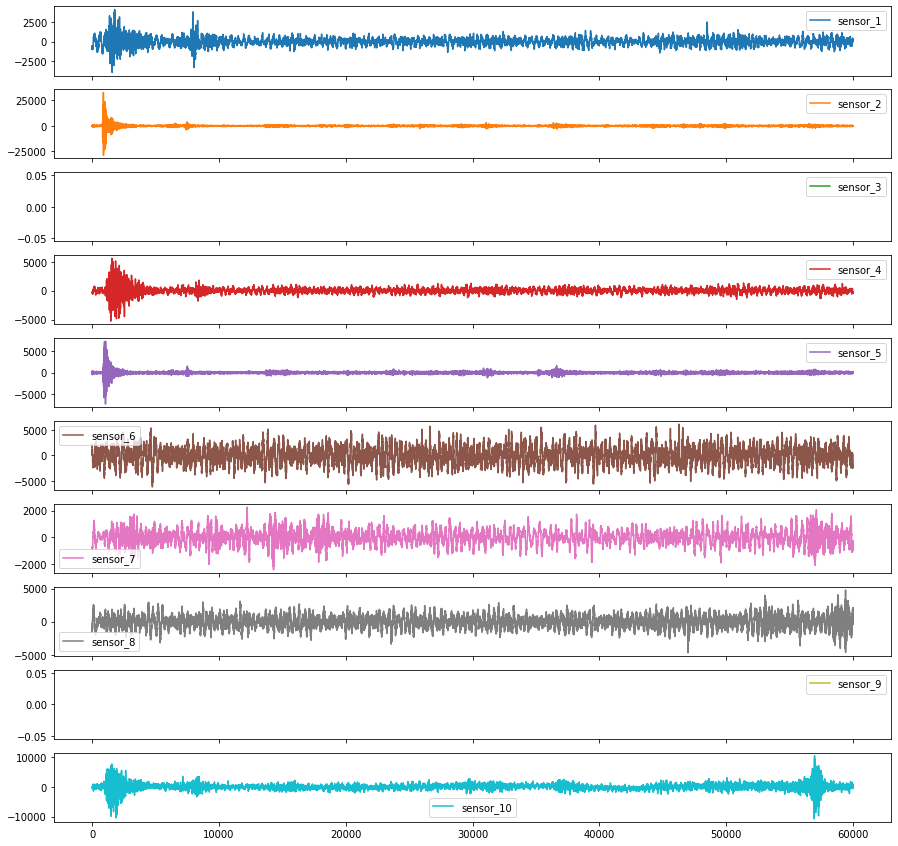

In [ ]:
example.plot(figsize=(15,15), subplots=True);

In [ ]:
train_time[train_time.segment_id == int(train_list[0].split('.')[0])]

,segment_id,time_to_eruption
699,800654756,16818516


In [ ]:
pd.DataFrame(example.fillna(0).describe().iloc[1:, :].unstack()).reset_index()

,level_0,level_1,0
0,sensor_1,mean,4.114265
1,sensor_1,std,470.544946
2,sensor_1,min,-3891.000000
3,sensor_1,25%,-273.000000
4,sensor_1,50%,0.000000
...,...,...,...
65,sensor_10,min,-10709.000000
66,sensor_10,25%,-473.000000
67,sensor_10,50%,0.000000
68,sensor_10,75%,487.000000


In [ ]:
process = pd.DataFrame(example.fillna(0).describe().iloc[1:, :].unstack()).reset_index()
process = process.rename(columns={0: 'value'})
process['feature'] = process['level_0'] + '_' + process['level_1']

In [ ]:
process

,level_0,level_1,value,feature
0,sensor_1,mean,4.114265,sensor_1_mean
1,sensor_1,std,470.544946,sensor_1_std
2,sensor_1,min,-3891.000000,sensor_1_min
3,sensor_1,25%,-273.000000,sensor_1_25%
4,sensor_1,50%,0.000000,sensor_1_50%
...,...,...,...,...
65,sensor_10,min,-10709.000000,sensor_10_min
66,sensor_10,25%,-473.000000,sensor_10_25%
67,sensor_10,50%,0.000000,sensor_10_50%
68,sensor_10,75%,487.000000,sensor_10_75%


In [ ]:
process = process.drop(['level_0', 'level_1'], axis=1).set_index('feature').T

In [ ]:
process

feature,sensor_1_mean,sensor_1_std,sensor_1_min,sensor_1_25%,sensor_1_50%,sensor_1_75%,sensor_1_max,sensor_2_mean,sensor_2_std,sensor_2_min,...,sensor_9_50%,sensor_9_75%,sensor_9_max,sensor_10_mean,sensor_10_std,sensor_10_min,sensor_10_25%,sensor_10_50%,sensor_10_75%,sensor_10_max
value,4.114265,470.544946,-3891.0,-273.0,0.0,286.0,4065.0,3.18048,1045.166153,-28726.0,...,0.0,0.0,0.0,8.997183,927.946272,-10709.0,-473.0,0.0,487.0,10389.0


In [ ]:
process['time'] = train_time[train_time.segment_id == int(train_list[0].split('.')[0])].time_to_eruption.values[0]

In [ ]:
process

feature,sensor_1_mean,sensor_1_std,sensor_1_min,sensor_1_25%,sensor_1_50%,sensor_1_75%,sensor_1_max,sensor_2_mean,sensor_2_std,sensor_2_min,...,sensor_9_75%,sensor_9_max,sensor_10_mean,sensor_10_std,sensor_10_min,sensor_10_25%,sensor_10_50%,sensor_10_75%,sensor_10_max,time
value,4.114265,470.544946,-3891.0,-273.0,0.0,286.0,4065.0,3.18048,1045.166153,-28726.0,...,0.0,0.0,8.997183,927.946272,-10709.0,-473.0,0.0,487.0,10389.0,16818516


In [ ]:
pd.DataFrame(example.fillna(0).skew()).T

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
0,0.210301,0.637362,0.0,0.153396,0.558969,-0.019516,-0.033914,-0.022177,0.0,-0.219034


# Preprocessing Train and Test

Create a function for data preparation

In [ ]:
def create_frame(data, data_time=None, type_data='train'):
    data = data.fillna(0)
    
    # основные статистика
    data_transform = data.describe().iloc[1:, :]
    
    # Дополнительные параметры
    # Коэффициент асимметрии
    data_transform.loc['skew'] = data.skew().tolist()
    
    #Среднее абсолютное отклонение
    data_transform.loc['mad'] = data.mad().tolist()
    
    # Коэффициент эксцесса — мера остроты пика распределения случайной величины.
    data_transform.loc['kurtosis'] = data.kurtosis().tolist()
    
    # добавление квантилей
    for i in range(0, 100, 5):
        if ((i!=25) & (i!=50)):
                str_col = f"{i}%"
                int_col = float(i)/100
                data_transform.loc[str_col] = data_transform.quantile(int_col).tolist()
        else:
            continue
            
    data_transform = pd.DataFrame(data_transform.unstack()).reset_index()
    data_transform = data_transform.rename(columns={0: 'value'})
    data_transform['feature'] = data_transform['level_0'] + '_' + data_transform['level_1']
    data_transform = data_transform.drop(['level_0', 'level_1'], axis=1).set_index('feature').T
    
    if type_data=='train':
        data_transform['time'] = data_time
    return data_transform

In [ ]:
all_train = pd.DataFrame()

for file in tqdm(train_list):
    df = pd.read_csv(PATH + 'train/' + file)
    data_time = train_time[train_time.segment_id == int(file.split('.')[0])].time_to_eruption.values[0]
    df = create_frame(df, data_time, type_data='train')
    all_train = all_train.append(df)

all_train = all_train.reset_index(drop=True)

100%|██████████| 4431/4431 [22:24<00:00,  3.30it/s]


In [ ]:
all_test = pd.DataFrame()

for file in tqdm(test_list):
    df = pd.read_csv(PATH + 'test/' + file)
    df = create_frame(df, data_time=None, type_data='test')
    all_test = all_test.append(df)

all_test = all_test.reset_index(drop=True)

100%|██████████| 4520/4520 [21:35<00:00,  3.49it/s]


In [ ]:
all_train[:5]

feature,sensor_1_mean,sensor_1_std,sensor_1_min,sensor_1_25%,sensor_1_50%,sensor_1_75%,sensor_1_max,sensor_1_skew,sensor_1_mad,sensor_1_kurtosis,...,sensor_10_45%,sensor_10_55%,sensor_10_60%,sensor_10_65%,sensor_10_70%,sensor_10_80%,sensor_10_85%,sensor_10_90%,sensor_10_95%,time
0,4.114265,470.544946,-3891.0,-273.0,0.0,2.162283,4065.0,0.210301,348.802605,5.531386,...,-10709.0,-1496.6,-283.887614,-0.219034,-0.065710,7.197747,10.643503,387.313354,855.341853,16818516
1,-0.145998,584.061135,-2165.0,-382.0,0.0,0.003277,2610.0,0.006554,460.779468,0.266137,...,-4234.0,-971.5,-365.400000,0.000000,0.010499,0.059772,0.312515,443.120102,891.817753,10340827
2,0.825053,262.683950,-1242.0,-163.0,0.0,0.449688,1435.0,0.074322,202.104232,1.083767,...,-3299.0,-624.2,-197.586437,-3.466092,-1.047182,-0.002101,0.788311,248.000961,508.938596,40087733
3,-1.490725,598.164998,-2310.0,-428.0,0.0,-0.095267,2370.0,-0.009542,483.291742,-0.180992,...,-4398.0,-1141.8,-468.031834,-0.079585,-0.023875,0.036425,8.601868,560.726642,1094.653014,31317486
4,-0.737071,399.197472,-2717.0,-213.0,0.0,0.175911,3812.0,0.351822,279.638276,8.513519,...,-4081.0,-774.4,-244.200000,0.000000,0.190551,2.475901,4.101904,313.123883,653.915681,5801334


In [ ]:
all_test[:5]

feature,sensor_1_mean,sensor_1_std,sensor_1_min,sensor_1_25%,sensor_1_50%,sensor_1_75%,sensor_1_max,sensor_1_skew,sensor_1_mad,sensor_1_kurtosis,...,sensor_10_40%,sensor_10_45%,sensor_10_55%,sensor_10_60%,sensor_10_65%,sensor_10_70%,sensor_10_80%,sensor_10_85%,sensor_10_90%,sensor_10_95%
0,2.934168,469.553705,-2035.0,-313.0,0.0,0.089316,1768.0,0.008376,371.762610,0.170257,...,-3401.0,-3401.0,-822.5,-322.817766,-3.044416,-0.928854,-0.004437,0.171183,386.025174,773.094239
1,-2.721021,324.254991,-2101.0,-207.0,0.0,-0.037527,1884.0,-0.075053,250.818417,1.160786,...,-4645.0,-4645.0,-817.3,-235.200000,0.000000,0.020921,1.917344,3.959745,304.250305,631.892835
2,-1.021166,187.078093,-830.0,-122.0,0.0,-0.024409,811.0,-0.048817,147.487040,0.256339,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.394010,220.053325,-1078.0,-146.0,0.0,0.105554,904.0,0.022154,174.231944,0.188954,...,-2167.0,-2167.0,-518.2,-205.180204,-10.450509,-3.169848,-0.009913,0.092503,233.165920,464.205400
4,-3.621906,257.255088,-2004.0,-146.0,0.0,-0.097519,1681.0,-0.195039,189.118104,3.527613,...,-4229.0,-4229.0,-705.5,-189.368531,-2.421326,-0.784098,-0.016486,2.490256,249.651451,531.367886


# Modeling

In [ ]:
X = all_train.drop('time',axis=1)
y = all_train['time']

test = all_test.copy()

#  Baseline

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=True, random_state=10)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, shuffle=True, random_state=10)

In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

CatBoost is an open-source software library developed by Yandex. It provides a gradient boosting framework which among other features attempts to solve for Categorical features using a permutation driven alternative compared to the classical algorithm.

In [ ]:
clf = CatBoostRegressor(loss_function='MAPE')  
train_dataset = Pool(data=X_train,
                     label=y_train,
                     )
    
eval_dataset = Pool(data=X_val,
                    label=y_val,
                    )
    
clf.fit(train_dataset,
          use_best_model=True,
          verbose = 0,
          eval_set=eval_dataset)

In [ ]:
y_pred = clf.predict(Pool(data=X_test))
    
print(f"MAPE: {mape(y_test, y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")

MAPE: 0.8902223116424627
MAE: 16691321.883976629
RMSE: 20466697.72996543


# Using KFold with some parametrs

We are going to use KFold with CatBoostRegressor. We didn't use GridSearch because save time

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=True, random_state=10)

In [ ]:
n_fold = 5
cv = KFold(n_splits=n_fold, shuffle=True, random_state=10)
prediction = np.zeros(len(test))
mape_, mae, rmse = [], [], []

params = {
            'iterations':1000,
            'learning_rate':0.1,
            'depth':6,
            'eval_metric':'RMSE'
}

for fold, (train_index, val_index) in enumerate(cv.split(X)):
    X_train = X.iloc[train_index,:]
    X_val = X.iloc[val_index,:]

    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]
          
    clf = CatBoostRegressor(**params)  
    
    train_dataset = Pool(data=X_train,
                     label=y_train,
                     )
    
    eval_dataset = Pool(data=X_val,
                    label=y_val,
                    )
    
    clf.fit(train_dataset,
              use_best_model=True,
              verbose = 0,
              eval_set=eval_dataset)
   
    y_pred = clf.predict(Pool(data=X_test))
    
    mape_.append(mape(y_test, y_pred))
    mae.append(mean_absolute_error(y_test, y_pred))
    rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))

    print(f"fold: {fold}, MAPE: {mape(y_test, y_pred)}")
    print(f"fold: {fold}, MAE: {mean_absolute_error(y_test, y_pred)}")
    print(f"fold: {fold}, RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")

    # test array predictions
    prediction += clf.predict(Pool(data=test))
        
prediction /= n_fold

print('CV mean MAPE:  {0:.4f}, std: {1:.4f}.'.format(np.mean(mape_), np.std(mape_)))
print('CV mean MAE: {0:.4f}, std: {1:.4f}.'.format(np.mean(mae), np.std(mae)))
print('CV mean RMSE: {0:.4f}, std: {1:.4f}.'.format(np.mean(rmse), np.std(rmse)))

fold: 0, MAPE: 0.6187342488114213
fold: 0, MAE: 3641438.335772745
fold: 0, RMSE: 5253019.880630902
fold: 1, MAPE: 0.37310375718291344
fold: 1, MAE: 1332216.295273419
fold: 1, RMSE: 2673715.638031606
fold: 2, MAPE: 0.11501361223215253
fold: 2, MAE: 635236.0163622742
fold: 2, RMSE: 838342.2902830465
fold: 3, MAPE: 0.13120921266815777
fold: 3, MAE: 605853.062263884
fold: 3, RMSE: 806425.250295085
fold: 4, MAPE: 0.13483133219315147
fold: 4, MAE: 689705.3964008449
fold: 4, RMSE: 902025.8447556287
CV mean MAPE:  0.2746, std: 0.1968.
CV mean MAE: 1380889.8212, std: 1161625.2565.
CV mean RMSE: 2094705.7808, std: 1730364.2243.


https://catboost.ai/docs/concepts/python-usages-examples.html

In [ ]:
sub_example = pd.read_csv(PATH + 'sample_submission.csv')
sub_example[:5]

,segment_id,time_to_eruption
0,1000213997,0
1,100023368,0
2,1000488999,0
3,1001028887,0
4,1001857862,0


In [ ]:
test_index = [int(i.split('.')[0]) for i in test_list]

In [ ]:
test_index[:5]

[473253715, 698018079, 1102809614, 1087681649, 1939361933]

In [ ]:
submission = pd.DataFrame()
submission['segment_id'] = test_index
submission['time_to_eruption'] = prediction
submission.to_csv('submission.csv', header=True, index=False)

In [ ]:
submission[:5]

,segment_id,time_to_eruption
0,473253715,3.807897e+07
1,698018079,7.876040e+06
2,1102809614,2.446946e+07
3,1087681649,3.056742e+07
4,1939361933,2.843890e+07
